<a href="https://colab.research.google.com/github/ericklpps/odontogenda-sprint4-IOT/blob/main/Sprint_4_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

A proposta que tentamos implementar nas sprints anteriores foi a seguinte:
 a utilização dos dados de consultas para podermos mapear possíveis contratempos nas clínicas como, verificar horários e dias de maior pico, a tendência de cancelamento dos clientes, melhores horários para os tipos de situações.

Agora, tivemos uma expansão e tratamento desses dados para evitar erros nas nossas análises


# Imports



In [ ]:
import pandas as pd
import sqlite3

import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Conexão com o banco de dados


In [ ]:
def conectar_banco(db_name='consultas.db'):
    try:
        conn = sqlite3.connect(db_name)
        print(f"Conectado ao banco de dados: {db_name}")
        return conn, conn.cursor()
    except sqlite3.Error as e:
        print(f"Erro ao conectar ao banco de dados: {e}")
        return None, None

# Conexão com o banco
conn, cursor = conectar_banco()

Conectado ao banco de dados: consultas.db


# Criação da tabela para armazenamento das consultas odontológicas

In [ ]:
def criar_tabela_consultas(cursor):
    try:
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS consultas (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            paciente TEXT,
            especialidade TEXT,
            dia_semana TEXT,
            horario TEXT,
            data TEXT
        )
        ''')
        print("Tabela 'consultas' criada com sucesso.")
    except sqlite3.Error as e:
        print(f"Erro ao criar tabela: {e}")

# Criar a tabela
criar_tabela_consultas(cursor)
conn.commit()


Tabela 'consultas' criada com sucesso.


# Populando o banco



In [ ]:
def popular_consultas(cursor, num_registros=100):
    especialidades = ['Ortodontia', 'Endodontia', 'Periodontia', 'Odontopediatria', 'Implantodontia']
    dias_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']
    horarios_disponiveis = [f'{hora:02d}:{minuto:02d}:00' for hora in range(8, 18) for minuto in (0, 30)]
    datas = [datetime.now().date() - timedelta(days=i) for i in range(30)]

    for _ in range(num_registros):
        paciente = f'Paciente_{random.randint(1, 100)}'
        especialidade = random.choice(especialidades)
        dia_semana = random.choice(dias_semana)
        horario = random.choice(horarios_disponiveis)
        data = random.choice(datas)

        try:
            cursor.execute('''
                INSERT INTO consultas (paciente, especialidade, dia_semana, horario, data)
                VALUES (?, ?, ?, ?, ?)
            ''', (paciente, especialidade, dia_semana, horario, data))
        except sqlite3.Error as e:
            print(f"Erro ao inserir consulta: {e}")

    conn.commit()
    print(f"{num_registros} registros inseridos com sucesso.")

# Inserir os registros
popular_consultas(cursor, 100)



100 registros inseridos com sucesso.


# Leitura dos dados inseridos


Aqui ao fazer as inserções, agora garantimos que não seja possível adicionar consultas em dias e horários já agendados, evitando duplicatas, o que poderia congestionar nossa análise

In [ ]:
def carregar_dados(conn):
    try:
        df = pd.read_sql_query("SELECT * FROM consultas", conn)

        # Remover linhas duplicadas (se existirem)
        df.drop_duplicates(inplace=True)

        # Converter a coluna 'data' para datetime
        df['data'] = pd.to_datetime(df['data'], errors='coerce')

        # Verificar se existem dados nulos
        nulos = df.isna().sum()
        if nulos.any():
            print("Dados nulos encontrados:")
            print(nulos)
        else:
            print("Nenhum dado nulo encontrado.")

        # Mostrar amostra dos dados carregados
        display(df.head())

        return df
    except Exception as e:
        print(f"Erro ao carregar os dados: {e}")
        return pd.DataFrame()

# Carregar os dados para análise
df_consultas = carregar_dados(conn)


Nenhum dado nulo encontrado.


,id,paciente,especialidade,dia_semana,horario,data
0,1,Paciente_59,Odontopediatria,Segunda-feira,16:30:00,2025-05-07
1,2,Paciente_2,Endodontia,Sábado,14:00:00,2025-04-27
2,3,Paciente_11,Periodontia,Sexta-feira,17:00:00,2025-05-09
3,4,Paciente_14,Implantodontia,Quinta-feira,17:30:00,2025-05-17
4,5,Paciente_33,Odontopediatria,Terça-feira,17:00:00,2025-05-14


# Análise de demandas


Temos análise de demandas da clínica baseadas em diversos fatores:

*   Horários de maior demanda
*   Tipos de operações
*   Dias da semana

Expandir a análise é fundamental para entendermos o comportamento dos clientes e fortalecer o planejamento de cada clínica.





📊 Horários com maior número de consultas:


,horario,total_consultas
16,16:00:00,10
17,16:30:00,8
8,12:00:00,8
14,15:00:00,8
3,09:30:00,7


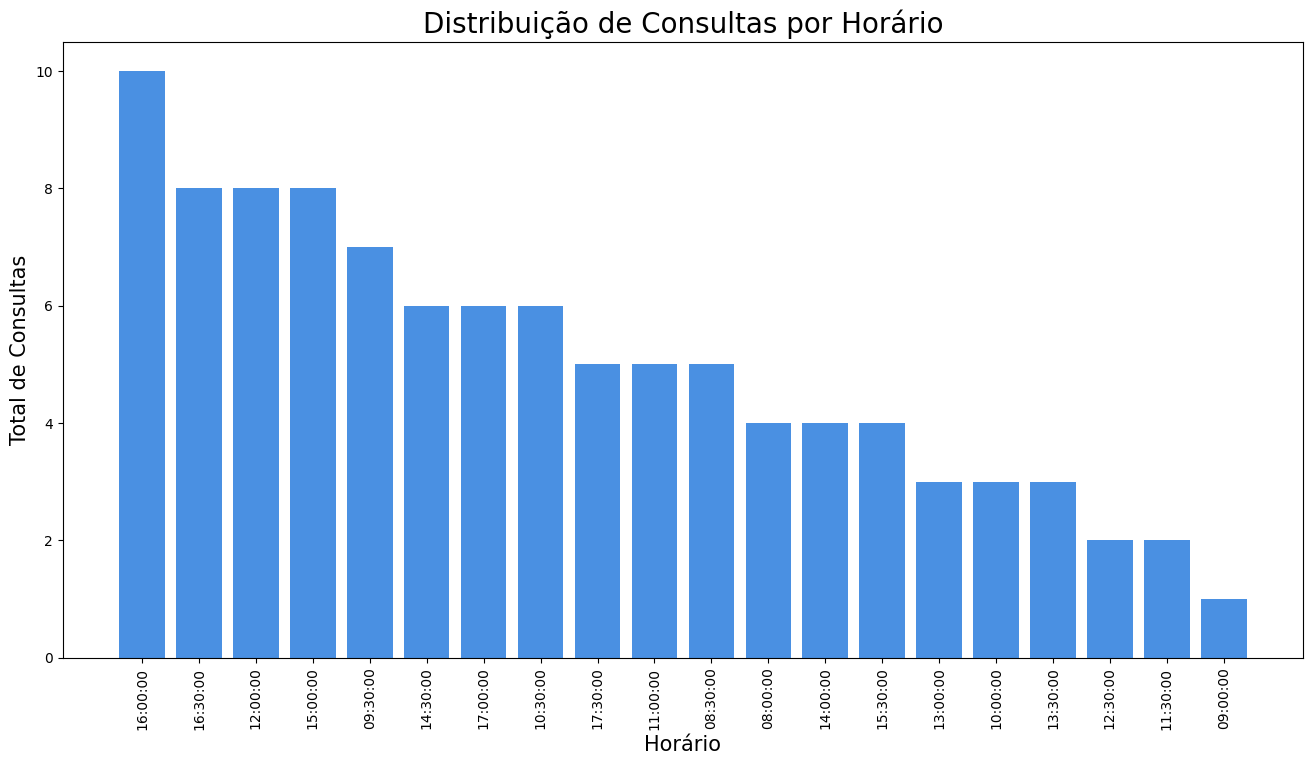


🩺 Consultas por Especialidade:


,especialidade,total_consultas
3,Ortodontia,25
2,Odontopediatria,20
0,Endodontia,19
1,Implantodontia,19
4,Periodontia,17


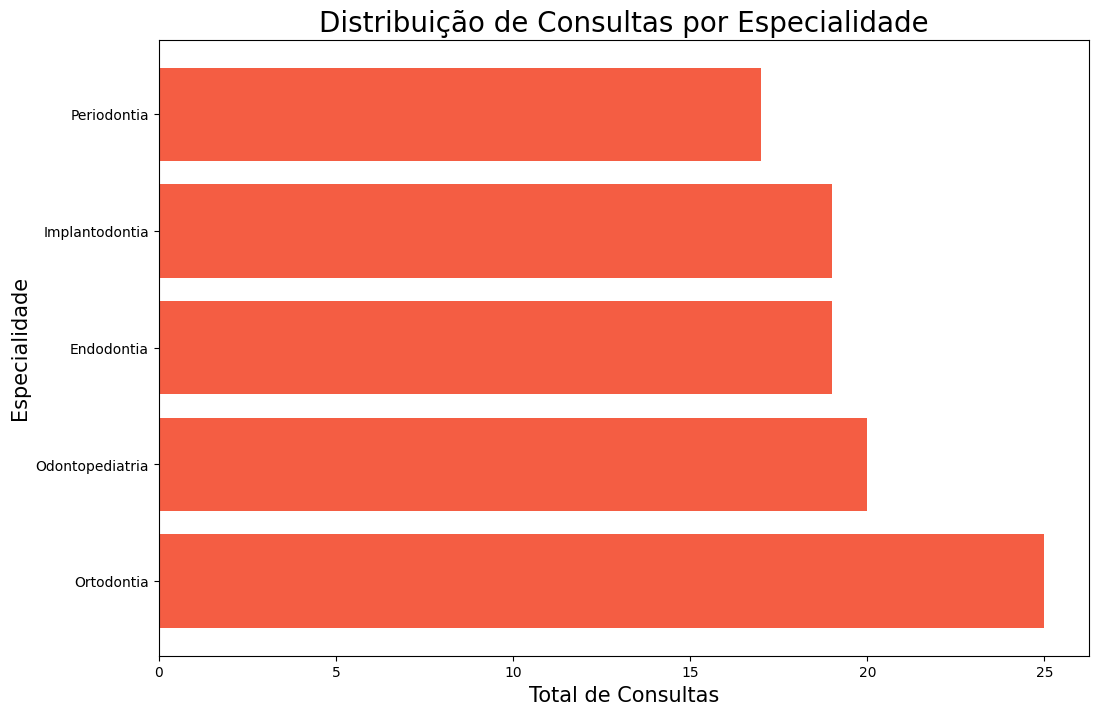


📅 Consultas por Dia da Semana:


,dia_semana,total_consultas
3,Sexta-feira,21
5,Terça-feira,20
2,Segunda-feira,16
0,Quarta-feira,15
1,Quinta-feira,14
4,Sábado,14


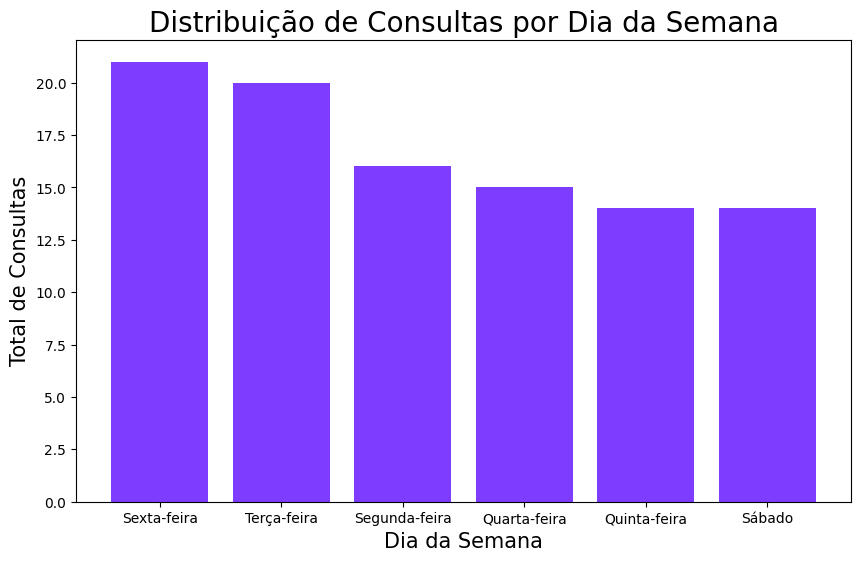

In [ ]:
def analisar_consultas(df):
    try:
        # Contagem de consultas por horário
        df_horarios = df.groupby('horario').size().reset_index(name='total_consultas')
        df_horarios.sort_values(by='total_consultas', ascending=False, inplace=True)

        # Exibir os 5 horários mais ocupados
        print("📊 Horários com maior número de consultas:")
        display(df_horarios.head())

        # Gráfico de distribuição de horários
        plt.figure(figsize=(16, 8))
        plt.bar(df_horarios['horario'], df_horarios['total_consultas'], color='#4a90e2')
        plt.xticks(rotation=90)
        plt.title('Distribuição de Consultas por Horário', fontsize=20)
        plt.xlabel('Horário', fontsize=15)
        plt.ylabel('Total de Consultas', fontsize=15)
        plt.show()

        # Análise por especialidade
        df_especialidade = df.groupby('especialidade').size().reset_index(name='total_consultas')
        df_especialidade.sort_values(by='total_consultas', ascending=False, inplace=True)

        print("\n🩺 Consultas por Especialidade:")
        display(df_especialidade)

        # Gráfico de especialidades
        plt.figure(figsize=(12, 8))
        plt.barh(df_especialidade['especialidade'], df_especialidade['total_consultas'], color='#f45d43')
        plt.title('Distribuição de Consultas por Especialidade', fontsize=20)
        plt.xlabel('Total de Consultas', fontsize=15)
        plt.ylabel('Especialidade', fontsize=15)
        plt.show()

        # Análise por dia da semana
        df_dias = df.groupby('dia_semana').size().reset_index(name='total_consultas')
        df_dias.sort_values(by='total_consultas', ascending=False, inplace=True)

        print("\n📅 Consultas por Dia da Semana:")
        display(df_dias)

        # Gráfico de dias da semana
        plt.figure(figsize=(10, 6))
        plt.bar(df_dias['dia_semana'], df_dias['total_consultas'], color='#7d3cff')
        plt.title('Distribuição de Consultas por Dia da Semana', fontsize=20)
        plt.xlabel('Dia da Semana', fontsize=15)
        plt.ylabel('Total de Consultas', fontsize=15)
        plt.show()

        return df_horarios, df_especialidade, df_dias

    except Exception as e:
        print(f"Erro ao analisar os dados: {e}")
        return None, None, None

# Analisar as consultas
df_horarios, df_especialidade, df_dias = analisar_consultas(df_consultas)


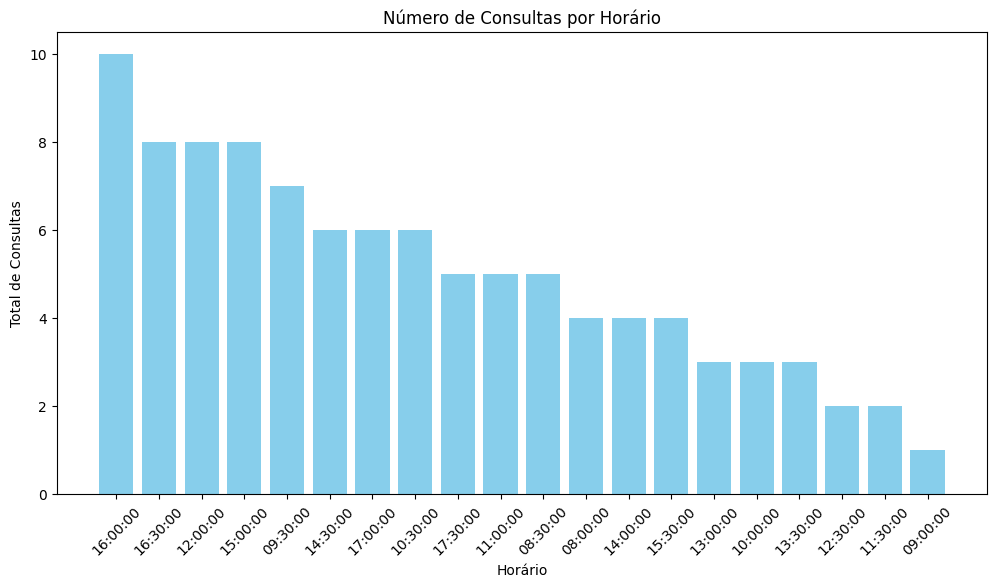

In [ ]:
# Exibição gráfica
plt.figure(figsize=(12,6))

plt.bar(df_horarios['horario'], df_horarios['total_consultas'], color='skyblue')

plt.xticks(rotation=45)

plt.title('Número de Consultas por Horário')
plt.xlabel('Horário')
plt.ylabel('Total de Consultas')

plt.show()

# Implementação de um sistema de recomendação

Esse sistema de recomendações irá recomendar, baseado no tipo de atendimento, dia da semana, consultas recomendadas por dia para esse tipo de operação.

In [ ]:
def recomendar_horario(df, dia_semana, especialidade, top_n=3):
    try:
        # Filtrar consultas pelo dia da semana e especialidade
        consultas_filtradas = df[
            (df['dia_semana'] == dia_semana) &
            (df['especialidade'] == especialidade)
        ]

        if consultas_filtradas.empty:
            print(f"Não há registros para {especialidade} na/no {dia_semana}.")
            return None

        # Contar a frequência de cada horário
        frequencia_horarios = consultas_filtradas['horario'].value_counts()

        # Identificar os horários menos ocupados
        horarios_recomendados = frequencia_horarios.nsmallest(top_n)

        print(f"\n Horários recomendados para {especialidade} na/no {dia_semana}:")
        for horario, total in horarios_recomendados.items():
            print(f"- {horario} ({total} consultas)")

        return horarios_recomendados

    except Exception as e:
        print(f"Erro ao recomendar horários: {e}")
        return None

# Testando para diferentes dias e especialidades
dias_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']
especialidades = ['Ortodontia', 'Endodontia', 'Periodontia', 'Odontopediatria', 'Implantodontia']

for dia in dias_semana:
    for especialidade in especialidades:
        recomendar_horario(df_consultas, dia, especialidade, top_n=3)



 Horários recomendados para Ortodontia na/no Segunda-feira:
- 08:30:00 (1 consultas)
- 12:00:00 (1 consultas)

 Horários recomendados para Endodontia na/no Segunda-feira:
- 17:00:00 (1 consultas)
- 16:00:00 (1 consultas)

 Horários recomendados para Periodontia na/no Segunda-feira:
- 12:00:00 (1 consultas)
- 14:00:00 (1 consultas)

 Horários recomendados para Odontopediatria na/no Segunda-feira:
- 16:30:00 (1 consultas)
- 13:00:00 (1 consultas)
- 10:30:00 (1 consultas)

 Horários recomendados para Implantodontia na/no Segunda-feira:
- 11:30:00 (1 consultas)
- 10:30:00 (1 consultas)
- 08:00:00 (1 consultas)

 Horários recomendados para Ortodontia na/no Terça-feira:
- 15:30:00 (1 consultas)
- 09:30:00 (1 consultas)
- 16:30:00 (2 consultas)

 Horários recomendados para Endodontia na/no Terça-feira:
- 15:00:00 (1 consultas)
- 11:00:00 (1 consultas)
- 08:30:00 (1 consultas)

 Horários recomendados para Periodontia na/no Terça-feira:
- 17:00:00 (1 consultas)
- 12:00:00 (1 consultas)

 Horár